# Clase sensores inerciales para analizar movimiento humano

¡Bienvenido a la clase!

El propósito de esta clase es entender como podemos analizar el movimiento humano a partir de sensores inerciales.

En Biomecánica IBIO contamos con 25 sensores inerciales XSENS DOT que usaremos hoy. Antes de ir a ello necesitaré que descargues dos cosas muy importantes:

**Aplicación Movella DOT:** En tu celular Android o iOS, ve a tu tienda de aplicaciónes y descarga la APP Movella DOT, esta te servirá para adquirir los datos con los sensores inerciales.

**Exportador de datos:** Los datos que registras con el sensor inercial se encuentran en su memoria interna, para extraerlos, puedes hacerlo directamente de la aplicación o, extraerlos desde la aplicación exportador nativa de Movella DOT (recomendable). Para ello, requiero por favor que vayas al siguiente link desde tu computador:

https://www.movella.com/support/software-documentation?hsCtaTracking=39d661fa-2ea8-4478-955e-01d0d8885f14%7C3ad1c7d6-9c3a-42e9-b424-5b15b9d0924e

Desde allí, baja la página y ubícate en la pestaña:
Movella DOT> Último software estable - Exportador > Exportador de datos Movella DOT (Windows) para la versión de firmware 2.4.0 y superiores.

Descarga e instala por favor el exportador.

**Para usar el exportador:** 
1. Ve a la ubicación de una carpeta llamada Movella_DOT_Data_Exporter-2023.6.0-Windows
2. Dirígete a donde se indica Movella_Dot_Data_Exporter.exe e instala ese archivo de tipo Aplicación.
3. No abrirá nada directamente, si le das mas clicks, saldrá un mensaje que indica Java Script Error.
4. Lo que debes hacer es ir a tu buscador e ingresar en la barra de una nueva pestaña: http://localhost:8181/
5. Abrirá automáticamente el Exportador de los datos de XSENS DOT.

**¡Ahora sí estamos listos para empezar!**

# ACTIVIDADES PRÁCTICAS:

#### Actividad #1: Toma unos minutos para explorar los datos del sensor, visualiza en tiempo real la mayor cantidad de variables posibles para comprender cómo funciona.


TODO: Anota aquí algo que te haya parecido importante:

# Actividad 2: Pasos y Giros

Con ayuda de 1 o 2 sensores inerciales, realiza marcha en línea con giros ida y vuelta, calcular con alguna variable del sensor la cantidad de pasos y la cantidad de giros que da en máximo 20 segundos. El siguiente código te permitirá cargar y visualizar las variables más fácilmente.


**Formato general de los datos en el .csv al exportar:**
Columnas presentes:
- `PacketCounter` (contador de paquetes)
- `SampleTimeFine` (tiempo del muestreo; úsalo como eje de tiempo)
- `Quat_W`, `Quat_X`, `Quat_Y`, `Quat_Z` (cuaterniones de orientación)
- `dq_W`, `dq_X`, `dq_Y`, `dq_Z` (derivadas de cuaterniones/orientación incremental)
- `dv[1]`, `dv[2]`, `dv[3]` (incrementos de velocidad/“free acceleration” en ejes locales)
- `Acc_X`, `Acc_Y`, `Acc_Z` (aceleración)
- `Gyr_X`, `Gyr_Y`, `Gyr_Z` (velocidad angular)
- `Mag_X`, `Mag_Y`, `Mag_Z` (magnetómetro)
- `Status` (estado/calidad de muestra)


In [4]:
#Cargamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt

# Configuración de gráficos (sin estilos ni colores específicos)
plt.rcParams['figure.figsize'] = (9, 4)

## Carga de datos y gráficos rápidos
1. Cambia la ruta del archivo a tu CSV.
2. Revisa qué columnas hay y usa las que consideres para calcularlo

In [9]:
# CAMBIAR LA RUTA DEL ARCHIVO SEGÚN SEA NECESARIO
file_path = r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\GitHub\IMU_ClassActivity\data\sujeto1\muslo_der_val_D422CD002A96_20250224_133310.csv'

# Cargar datos
df = pd.read_csv(file_path)

In [11]:
# Definir frecuencia de muestreo LA QUE USTEDES USARON PARA TOMAR SUS DATOS
fs = 120.0  # Hz

# Crear columna de tiempo a partir del PacketCounter
df['Time'] = df['PacketCounter'] / fs

# Función para graficar cualquier señal
def plot_signal(variable):
    if variable not in df.columns:
        print(f"La variable '{variable}' no existe en el archivo.")
        print("Columnas disponibles:", list(df.columns))
        return
    plt.figure(figsize=(10,4))
    plt.plot(df['Time'], df[variable])
    plt.xlabel('Tiempo [s]')
    plt.ylabel(variable)
    plt.title(f'{variable} vs Tiempo')
    plt.grid(True)
    plt.show()


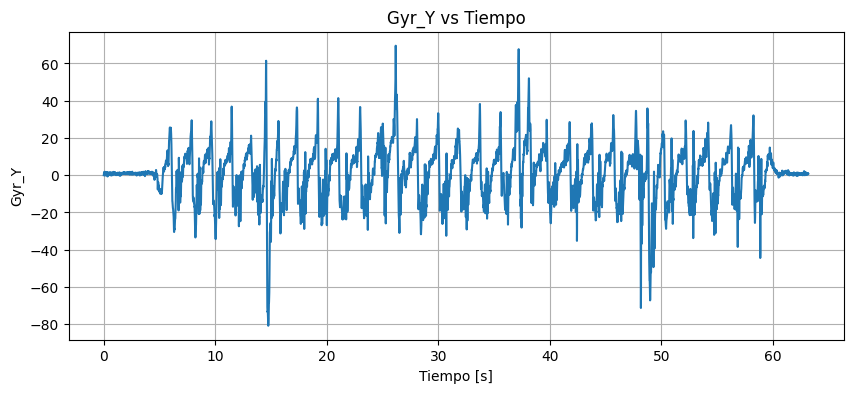

In [17]:
#### AQUI CAMBIAR UNICAMENTE EL NOMBRE DE LA VARIABLE A GRAFICAR ####

# Ejemplo: cambiar el nombre de la variable para ver otra señal
plot_signal('Gyr_Y')  # Cambiar 'GyroY' por cualquier otra columna del DataFrame

# Actividad 3: Cinemática de la Rodilla

Haremos este proceso revisando varias ubicaciones de los sensores:

1) Con Euler, a partir del análisis de la siguiente imagen y teniendo en cuenta los ejes locales del sensor
para calcular el ángulo de Flexión- Extensión de la rodilla.


### Tener en cuenta Yaw, pitch, roll (ZYX Euler Sequence) segun el fabricante

Los ángulos de Euler y los ejes de XSENS DOT se visualizan mejor en la siguiente imagen

<img src="yaw2.jpg" width="400"> <img src="xsensejes.jpg" width="400" height="400"> 

## CON EULER:

In [21]:
# ==== EDITA ESTAS RUTAS ====
THIGH_FILE = r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\GitHub\IMU_ClassActivity\data\euler\muslo_der_val_D422CD002A96_20250224_133310.csv'
SHANK_FILE = r'C:\Users\Valentina\OneDrive - Universidad de los andes\Documentos\GitHub\IMU_ClassActivity\data\euler\tibia_der_val_D422CD0041E2_20250224_133310.csv'
FS = 120.0  # Hz

# Cargar
t_df = pd.read_csv(THIGH_FILE)
s_df = pd.read_csv(SHANK_FILE)

In [22]:
# Usar el mismo largo o el mínimo si difieren
n = min(len(t_df), len(s_df))

# Tiempo desde PacketCounter
t = (t_df['PacketCounter'].to_numpy()[:n]) / FS

In [24]:
# Ángulo de rodilla (flexo-extensión) 

#CAMBIAR AQUI CUAL EULER REPRESENTA PARA CADA UNO DE LOS SENSORES ESE ANGULO

knee_deg = s_df['Euler_X'].to_numpy()[:n] - t_df['Euler_X'].to_numpy()[:n]

# Desenrollar (evita saltos ±180/360) y recentrar
knee_deg = np.rad2deg(np.unwrap(np.deg2rad(knee_deg)))
knee_deg = knee_deg - knee_deg[0]

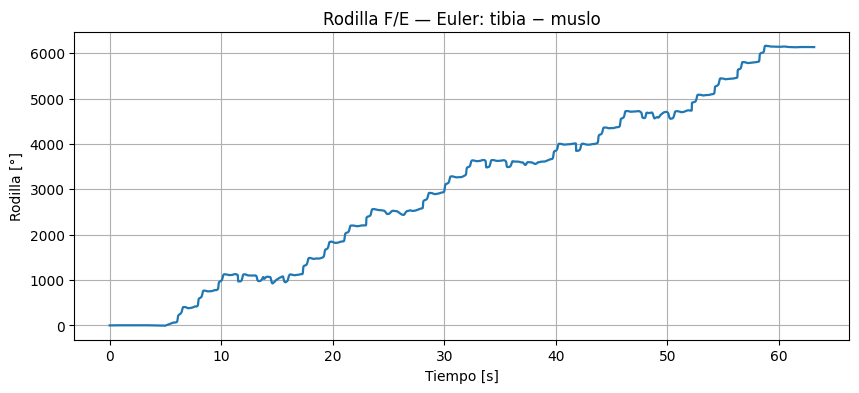

In [37]:
# Graficar
plt.figure(figsize=(10,4))
plt.plot(t, knee_deg, lw=1.6)
plt.xlabel('Tiempo [s]'); plt.ylabel('Rodilla [°]')
plt.title('Rodilla F/E — Euler: tibia − muslo')
plt.grid(True); plt.show()

## 4) Explora y cuestiona (Preguntas guía para el grupo)
- ¿Qué pasa si cambio el eje de aceleración para contar pasos? ¿Cuál funciona mejor y por qué?
- ¿Usar magnitud de aceleración ayuda cuando no conozco la orientación del sensor?
- ¿Qué eje de giroscopio representa mejor los **giros** (yaw)? ¿Qué pasa si el sensor no está vertical?
- En rodilla, ¿qué combinaciones de ejes dan una curva “parecida” a flexo-extensión? ¿Por qué la colocación lateral ayuda?
- ¿Qué filtros o parámetros (umbral, distancia mínima entre picos) mejoran la detección de pasos sin perder eventos?